# **Derin Öğrenme ile Tıbbi Görüntü Analizi - II**
## **NIFTI Formatındaki Beyin MR Görüntülerinin İncelenmesi**

# Tıbbi Görüntü Formatları
Radyoloji görüntüleri için 6 baskın format vardır - DICOM (Tıpta Dijital Görüntüleme ve İletişim), NIFTI (Nörogörüntüleme Bilişim Teknolojisi Girişimi), PAR / REC (Philips MRI tarayıcı formatları), ANALYZE (Mayo Medical Görüntüleme), NRRD (Neredeyse Ham Raster Verileri) ) ve MNIC.

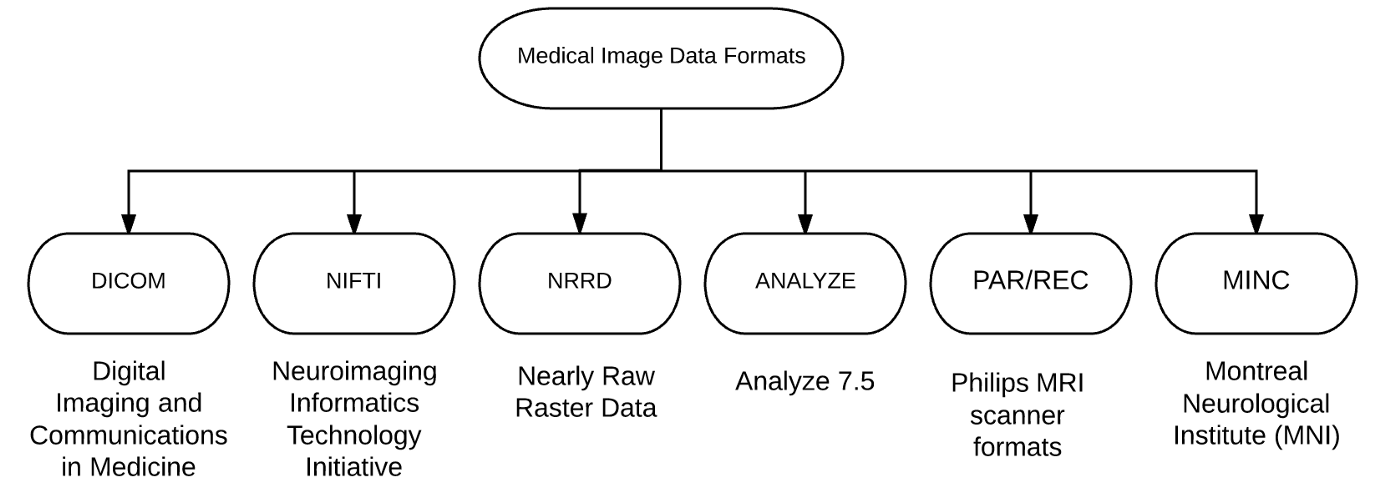

In [28]:
from IPython.display import Image
Image(filename='c.png') 

İlk konumuzda DICOM formatındaki tıbbi görüntüleri okumayı görmüştük. Bu uygulamada NIFTI formatında beyin MR görüntülerini inceleyeceğiz.

# **NIFTI Formatı**
NIFTI formatı, ANALYZE 7.5 Formatının yerini alan Nörogörüntüleme Bilişim Teknolojisi Girişimi (NIFTI) tarafından oluşturulmuştur. Nöro görüntüleme alanında kökeni vardır, ancak diğer alanlarda da kullanılabilir. Ana özellik, formatın her voksel indeksini (i, j, k) uzamsal bir konuma (x, y, z) bağlayan iki afin koordinat tanımı içermesidir.

Nifti dosyalarını okumak için bir python kütüphanesi **nibabel**'dir. 

# **DICOM ve NIFTI arasındaki farklar**
DICOM ve NIFTI arasındaki temel fark, NIFTI'daki ham görüntü verilerinin DICOM'da 2d görüntü dilimlerinin bulunduğu bir 3d görüntü olarak kaydedilmesidir. Bu, NIFTI'yı DICOM üzerinden bazı makine öğrenimi uygulamaları için daha tercih edilebilir kılmaktadır, çünkü bir 3d görüntü olarak modellenmiştir. Yüzlerce DICOM yerine tek bir NIFTI dosyasını kullanmak daha kolaydır. Nifti, DICOM'daki onlarca dosya yerine 3B görüntü için 2 dosya saklar. (.hdr ve .img uzantılı)

### Gerekli Kütüphaneler

In [1]:
import requests
import zipfile
import pandas as pd
import numpy as np
import os
import nibabel
import matplotlib.pyplot as plt

# Enable plots inside the Jupyter Notebook
%matplotlib inline

### Beyin MR Görüntülerinin ilgili sayfadan alınması, zipten çıkarılması ve 'fMRI_data' klasörüne kaydedilmesi

In [29]:
# Define the URL of the data and download it using the Requests libary
url = 'http://www.fil.ion.ucl.ac.uk/spm/download/data/MoAEpilot/MoAEpilot.zip'
data = requests.get(url)

# Check if the targed folder for storing the data already exists. If not create it and save the zip file.
if os.path.exists('./fMRI_data') == False:
    os.mkdir('fMRI_data')
    
open('./fMRI_data/data.zip', 'wb').write(data.content)

# Un-zip the file
zip_ref = zipfile.ZipFile('./fMRI_data/data.zip', 'r')
zip_ref.extractall('./fMRI_data/')
zip_ref.close()

### İlgili klasörden Yapısal verileri tutan .hdr uzantılı görüntü datalarının alınması

In [4]:
# Find all files in the structural data folder
data_path = './fMRI_data/sM00223/'
files = os.listdir(data_path)

# Read in the data
data_all = []
for data_file in files:
    if data_file[-3:] == 'hdr':
        data = nibabel.load(data_path + data_file).get_data()

# **Yapısal MRI verilerinin görselleştirilmesi**
### Veriyi **nibabel** kütüphanesinin yardımıyla yükledikten sonra , verinin gerçekten 4 Boyutlu olduğunu görebiliriz. İlk ikisi X ve Y düzlemleriyken, 3. boyut taramadaki dilim sayısını temsil eder. Dördüncü boyut herhangi bir bilgi içermez ve atılabilir.

In [5]:
print(data.shape)

(256, 256, 54, 1)


Yukarıdaki çıktı bize beynin dilim başına 256 x 256 voksel çözünürlükte 54 dilimde tarandığını söyler. Her dilimi görselleştirmek için verileri yeniden düzenlememiz gerekir.

In [6]:
data = np.rot90(data.squeeze(), 1)
print(data.shape)

(256, 256, 54)


Yukarıdaki kodun uygulanması veri kümesinin 4. boş boyutunu kaldırır ve görüntüleri bir sonraki adımda çizerken gözleri yukarı bakacak şekilde her dilimi döndürür.

* 54 dilimi değil de 0. dilimden başlayarak 10'un katı olan dilimleri görüntüleyelim

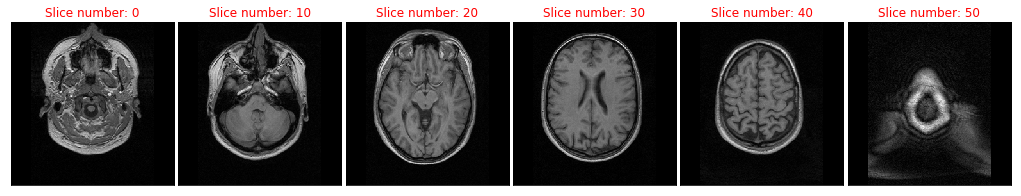

In [7]:
fig, ax = plt.subplots(1, 6, figsize=[18, 3]) # 6 çizim yapacağız

n = 0
slice = 0
for _ in range(6):
    ax[n].imshow(data[:, :, slice], 'gray')
    ax[n].set_xticks([])
    ax[n].set_yticks([])
    ax[n].set_title('Slice number: {}'.format(slice), color='r')
    n += 1
    slice += 10
    
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

# **İşlevsel MR görüntüleri**
Yapısal MRI görüntüleri, fonksiyonel MRI veya fMRI araştırması yapılan beyin veya diğer organlar hakkında çok fazla mekansal ayrıntı sağlarken, taramalar zamanla mekansal ayrıntıyı kaybetme pahasına gelen kan oksijen seviyesi bağımlılık sinyalini (BOLD sinyali) izler. Temel olarak BOLD sinyali, beyin aktivitesinin dolaylı bir ölçüsü olarak kullanılabilecek ancak nöral aktivitenin bir eşdeğeri olmayan beyin dokusunun kan oksijenasyonundaki değişiklikleri temsil eder.

# **Fonksiyonel MRG verilerini görselleştirme**
Şimdi fonksiyonel verilere bir göz atalım. Öncelikle veri seti ile birlikte gelen README.txt dosyasını açıyoruz çünkü burada veri toplama ile ilgili detaylar belgelenmiştir. Bunlara yalnızca fMRI dosyalarını okumak için değil aynı zamanda daha sonra verilerden anlam çıkarmak için de ihtiyacımız var. Şimdilik kilit parametreler her görüntünün boyutu (64 x 64 voksel), toplanan dilimlerin sayısı (64) ve kaç cildin elde edildiği (96); Bu, örneklenen zaman noktalarının sayısıdır. Eldeki bu bilgiler sayesinde verileri alabilir ve edinim parametrelerine göre yeniden şekillendirebiliriz. Veri klasörüne bakarken göreceğiniz gibi, 96 .hdr dosyası var, yani her bir dosya bir birim için tüm dilimleri içeriyor.


X ve Y-voksel sayısının bu taramadaki dilim sayısına eşit olduğunu zaten fark etmiş olabilirsiniz. SPM ana sayfasında, uzamsal boyutların 3mm x 3mm x 3mm voksel olduğu bilgisini de buluruz. Bu, verileri 3 uzamsal boyut boyunca bozulma olmadan döndürebileceğimiz anlamına gelir. Her öğenin sonuçta hacimsel bir piksel olduğunu unutmayın.

In [24]:
# Basic information about the data acquisition
x_size = 64
y_size = 64
n_slice = 64
n_volumes = 96

# Find all files in the data folder
data_path = './fMRI_data/fM00223/'
files = os.listdir(data_path)

# Read in the data and organize it with respect to the acquisition parameters
data_all = []
for data_file in files:
    if data_file[-3:] == 'hdr':
        data = nibabel.load(data_path + data_file).get_data()        
        data_all.append(data.reshape(x_size, y_size, n_slice))

Aşağıdaki kod verileri 3 ana anatomik düzleme göre yeniden düzenleyecektir : koronal, transversal ve sagital.

In [27]:
# Koronal düzlemde görselleştirme için verileri düzenleyin
coronal = np.transpose(data_all, [1, 3, 2, 0])
coronal = np.rot90(coronal, 1)

# Görselleştirme için verileri enine düzleminde düzenleyin 
transversal = np.transpose(data_all, [2, 1, 3, 0])
transversal = np.rot90(transversal, 2)

# Sagittal düzlemde görselleştirme için verileri düzenleyin
sagittal = np.transpose(data_all, [2, 3, 1, 0])
sagittal = np.rot90(sagittal, 1)

### Her 3 ana anatomik düzleme göre örnek görüntüleri görselleştirelim

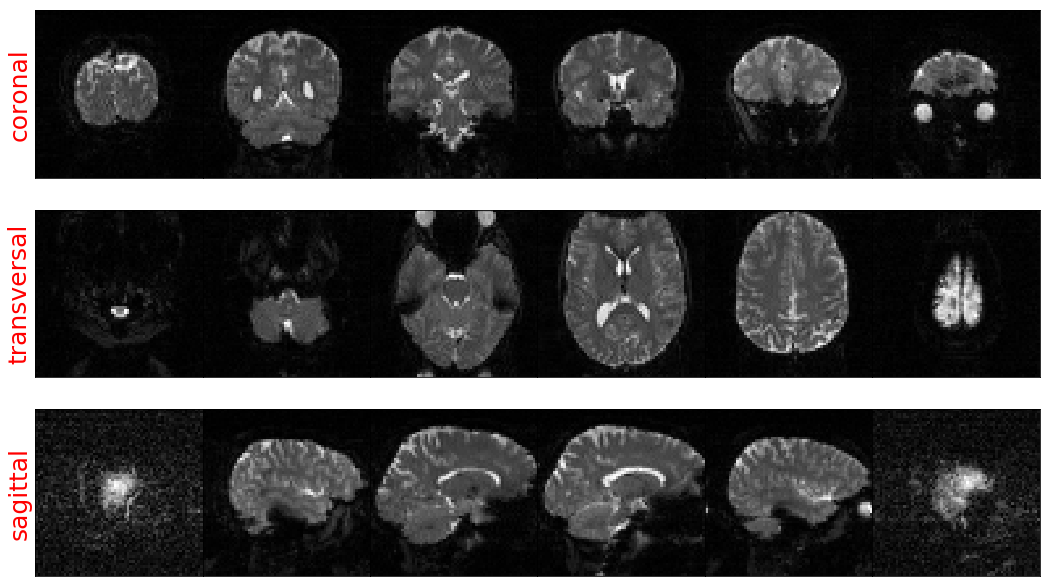

In [26]:
# Create a 3x6 subplot 
fig, ax = plt.subplots(3, 6, figsize=[18, 11])
# Plot some of the images in different planes
n = 10
for i in range(6):
    ax[0][i].imshow(coronal[:, :, n, 0], cmap='gray')
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    if i == 0:
        ax[0][i].set_ylabel('coronal', fontsize=25, color='r')
    n += 10
    
n = 5
for i in range(6):
    ax[1][i].imshow(transversal[:, :, n, 0], cmap='gray')
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    if i == 0:
        ax[1][i].set_ylabel('transversal', fontsize=25, color='r')
    n += 10
    
n = 5
for i in range(6):
    ax[2][i].imshow(sagittal[:, :, n, 0], cmap='gray')
    ax[2][i].set_xticks([])
    ax[2][i].set_yticks([])
    if i == 0:
        ax[2][i].set_ylabel('sagittal', fontsize=25, color='r')
    n += 10

fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

Bu yeniden organizasyon adımından sonra verileri Matplotlib ile çizebiliriz . Ancak, şimdi 2D görüntüde temsil edemediğimiz 4. zaman boyutuna sahip olduğumuzu unutmayın. Bu yüzden sadece ilk zaman çizelgesine bakarız. Aşağıdaki kod, koronal düzlem içindeki herhangi bir dilimi görselleştirmek için kullanılabilir.

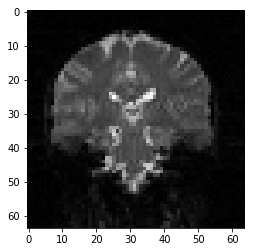

In [20]:
plt.imshow(coronal[:, :, 30, 0], cmap='gray')
plt.show()

# Veri dosyalarımızı .csv formatında kaydetme

In [11]:
# Rearrange and reshape data for export
data_all = np.transpose(data_all, [3, 2, 1, 0])
data_all = np.reshape(data_all, [n_slice, y_size*x_size, n_volumes])

# Check if output path exists, if not create it.
if os.path.exists('./fMRI_data/csv_data') == False:
    os.mkdir('./fMRI_data/csv_data')

# Export each slice as a .csv file 
n = 0
for export in data_all:

    save_file = 'slice_{}.csv'.format(n)
    save_path = './fMRI_data/csv_data/{}'.format(save_file)
    pd.DataFrame(export).to_csv(save_path, header=False, index=False)
    n += 1